In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import glob
import os
import re
import pandas as pd
import tarfile
from astroML.time_series import MultiTermFit
from gatspy import periodic
from astropy.table import Table

%matplotlib inline
sns.set(style="white", color_codes=True, context="poster")
sns.set(style="ticks", color_codes=True, context="poster")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

mainpath = '/Users/jorgetil/Astro/HITS'
paper_fig_path = '/Users/jorgetil/Astro/HITS/figures/'

In [2]:
def give_me_lc(field, CCD, X, Y, extract=False):
    year = field[:-3]
    try:
        tar = tarfile.open("%s/lightcurves/%s/%s/%s/%s_%s_LC_50.tar.gz" 
                           % (mainpath, year, field, CCD, field, CCD))
        fil = tar.extractfile('%s_%s_%s_%s_g.dat' % (field, CCD, X, Y))
        if extract:
            tar.extract('%s_%s_%s_%s_g.dat' % (field, CCD, X, Y),
                    path='/Users/jorgetil/Astro/HITS/lightcurves/samples/.')
    except:
        print 'No tar file or element in tar file'
        return None
    
    time, mag, err = [], [], []
    for line in fil:
        if line[0] == '#': continue
        values = line.split()
        time.append(float(values[1]))
        mag.append(float(values[2]))
        err.append(float(values[3]))
    time = np.asarray(time)
    mag= np.asarray(mag)
    err = np.asarray(err)
    
    try:
        fil = tar.extractfile('%s_%s_%s_%s_r.dat' % (field, CCD, X, Y))
        #tar.extract('%s_%s_%s_%s_r.dat' % (field, CCD, X, Y)
        #                , path='/Users/jorgetil/Downloads/.')
        time2, mag2, err2 = [], [], []
        for line in fil:
            if line[0] == '#': continue
            values = line.split()
            time2.append(float(values[1]))
            mag2.append(float(values[2]))
            err2.append(float(values[3]))
        time2 = np.asarray(time2)
        mag2 = np.asarray(mag2)
        err2 = np.asarray(err2)
        return time, mag, err, time2, mag2, err2
    except:
        print 'No lightcurve for other filter'
        return time, mag, err, None, None, None

In [3]:
# load feature table into DF
table_file = '%s/tables/HiTS_labeled.csv' % (mainpath)
#table_15 = Table.read(table_file).to_pandas()
table_15 = pd.read_csv(table_file)
table_15.set_index('internalID', inplace=True)

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(8921, 74)
NV        5000
QSO       3495
RRLYR      177
EB         110
CV          94
SNe         29
MISC         7
ROTVAR       5
ZZ           2
DSCT         1
LPV          1
Name: Var_Type, dtype: int64
(8911, 74)


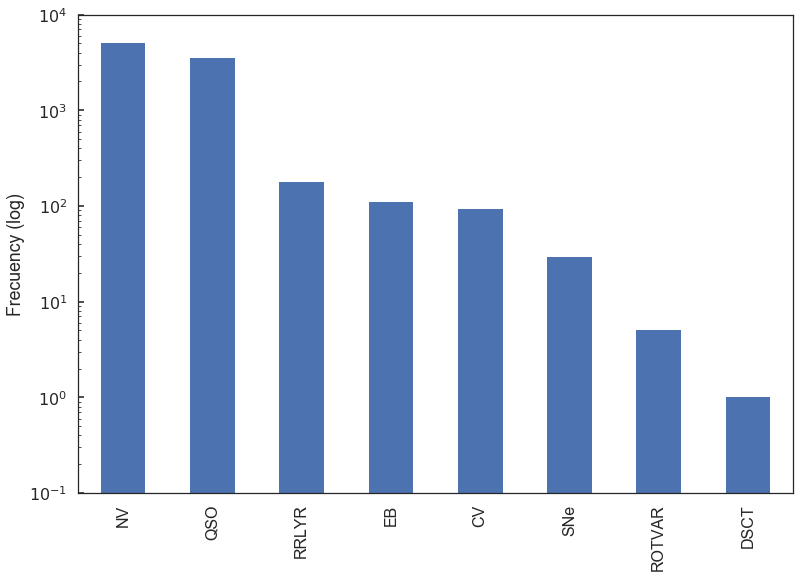

In [13]:
print table_15.shape
print table_15.Var_Type.value_counts()
print table_15.query('Var_Type != "ZZ" and Var_Type != "LPV" and Var_Type != "MISC"').shape
table_15.query('Var_Type != "ZZ" and Var_Type != "LPV" and Var_Type != "MISC"').Var_Type.value_counts().plot(kind="bar")
plt.ylabel('Frecuency (log)')
plt.yscale('log')
#plt.title('Labeled Sample')
plt.ylim(0.1,10000)
plt.show()

In [5]:
index_goods = ['Blind15A_04_N3_0096_0232','Blind15A_06_N24_1456_1709',
               'Blind15A_24_N20_1369_0209','Blind15A_34_N27_1247_0774',
               'Blind15A_36_S14_0610_4037',
               'Blind15A_16_S12_1264_0705','Blind15A_10_N17_1174_1967',
               'Blind15A_48_N13_1900_3489', 'Blind15A_27_N4_1137_0808',
               'Blind15A_16_N29_0097_2110']
clas = ['QSO','NV',
        'CV','SNe',
        'LPV',
        'RRLYR','EB',
        'ROTVAR','DSCT',
        'ZZ']

Blind15A_04_N3_0096_0232
Blind15A_06_N24_1456_1709
Blind15A_24_N20_1369_0209
Blind15A_34_N27_1247_0774


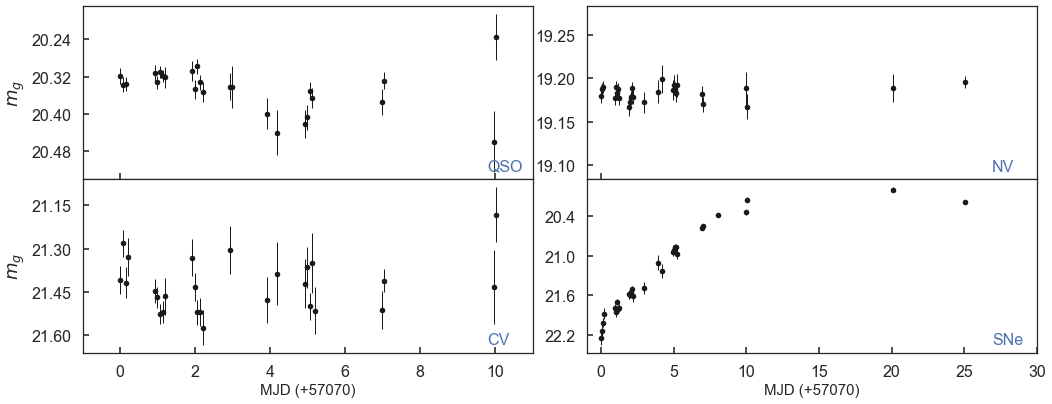

In [6]:
fig, ax = plt.subplots(2,2, figsize=(15,6))
for idx, ID in enumerate(index_goods[:4]):
    print '\r',ID
    label = clas[idx]
    #print table_15.loc[ID,['Var_Type','FLUX_RADIUS','ELLIPTICITY',
    #                       'FWHM','FLAGS','Mean','Median_g',
    #           'Std','MedianAbsDev','Meanvariance','Eta_e',
    #           'Pred_Var_Type','Prob_Pred','PeriodLS',
    #           'Period_fit', 'WMCC_Period', 'WMCC_conf']]
    #T = float(table_15.loc[ID,'PeriodLS'])
    #T = float(table_15.loc[ID,'WMCC_Period'])
    field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', ID)[0]
    try:
        time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD,
                                                       X, Y,extract=False)
    except:
        print 'fail during LC read'
        continue

    ax.ravel()[idx].errorbar(time-np.min(time), mag, yerr=err,
                             fmt='k.', lw=1, alpha=1)
    ax.ravel()[idx].set_xlabel('MJD (+%.0f)' % (np.min(time)), fontsize=15)
    ax.ravel()[idx].invert_yaxis()
    
    if idx in [0,2]:
        ax.ravel()[idx].set_ylabel('$m_g$', fontsize=18)
        ax.ravel()[idx].set_xlim(-1,11)
    else:
        ax.ravel()[idx].set_xlim(-1,30)
    if idx in [0,1]:
        ax.ravel()[idx].xaxis.set_major_locator(MaxNLocator(nbins=1, prune='both'))
    
    if label == 'NV':
        ax.ravel()[idx].set_ylim(np.mean(mag) - .1, np.mean(mag) + .1)
    ax.ravel()[idx].text(0.9, 0.12, label, fontsize=16, color='b',
                         ha='left', va='top', transform=ax.ravel()[idx].transAxes)
    
    ax.ravel()[idx].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
        
fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=.12)
fig.savefig('%s/figures/lc_examples_nonP.pdf' % (mainpath), format='pdf', dpi=600,
            bbox_inches='tight')
plt.show()

Blind15A_16_S12_1264_0705
Blind15A_10_N17_1174_1967
Blind15A_48_N13_1900_3489
Blind15A_27_N4_1137_0808


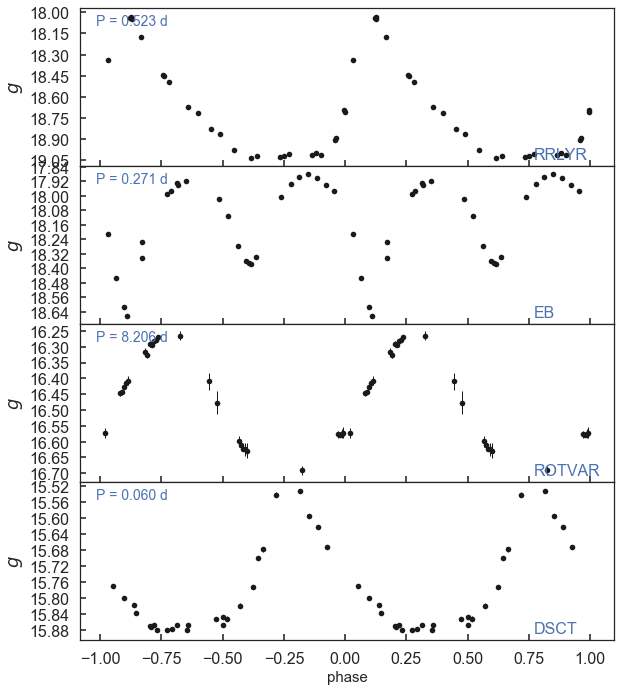

In [7]:
fig, ax = plt.subplots(4,1, figsize=(9,10), sharex=True)
for idx, ID in enumerate(index_goods[5:9]):
    print '\r',ID
    label = table_15.loc[ID,'Var_Type']
    #print table_15.loc[ID,['Var_Type','FLUX_RADIUS','ELLIPTICITY',
    #                       'FWHM','FLAGS','Mean','Median_g',
    #           'Std','MedianAbsDev','Meanvariance','Eta_e',
    #           'Pred_Var_Type','Prob_Pred','PeriodLS',
    #           'Period_fit', 'WMCC_Period', 'WMCC_conf']]
    if label in ['RRLYR', 'EB']:
        T = float(table_15.loc[ID,'PeriodLS'])
    else:
        T = float(table_15.loc[ID,'PeriodGLS'])
    #T = float(table_15.loc[ID,'WMCC_Period'])
    field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', ID)[0]
    try:
        time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD,
                                                       X, Y,extract=False)
    except:
        print 'fail during LC read'
        continue
        
    mask = (mag > np.median(mag) - 3*np.std(mag)) & (mag < np.median(mag) + 3*np.std(mag))
    if label == 'DSCT':
        mag = mag[mask]
        time = time[mask]
        err = err[mask]
        T = 0.060014
    if label == 'ZZ':
        T = 0.0029512
        
    if label == 'ROTVAR':
        T = 8.20567

    if label in ['EB'] : T *= 2
    phase = np.mod(time, T) / T
    sort_idx = np.argsort(phase)
    PHASE = phase[sort_idx]
    MAG = mag[sort_idx]
    ERR = err[sort_idx]
    
    MAG = np.concatenate([MAG,MAG])
    PHASE = np.concatenate([PHASE,PHASE+1])-1
    ERR = np.concatenate([ERR,ERR])

    ax.ravel()[idx].errorbar(PHASE, MAG, yerr=ERR,
                             fmt='k.', lw=1,alpha=1, label=label)
    ax.ravel()[idx].text(0.03, 0.96, "P = %.3f d" % (T), fontsize=14, color='b',
                         ha='left', va='top', transform=ax.ravel()[idx].transAxes)
    ax.ravel()[idx].text(0.85, 0.12, label, fontsize=16, color='b',
                         ha='left', va='top', transform=ax.ravel()[idx].transAxes)
    
    ax.ravel()[idx].set_xlabel('phase', fontsize=15)
    if label == 'ZZ':
        ax.ravel()[idx].set_ylim(np.median(MAG) - .05, np.median(MAG) + .05)
    
    ax.ravel()[idx].set_ylabel('$g$', fontsize=18)
    ax.ravel()[idx].invert_yaxis()
    nbins = len(ax.ravel()[idx].get_xticklabels())
    ax.ravel()[idx].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))

        
fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig('%s/figures/lc_examples_P.pdf' % mainpath, format='png', dpi=600,
            bbox_inches='tight')
plt.show()

In [8]:
table_15.query('Var_Type == "LPV"')

,ID,raMedian,decMedian,X,Y,spCl,spSubCl,Var_Type,Var_subType,Amplitude,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_36_S14_0610_4037,HiTS101615+023228,154.063185,2.541294,610.1212,4037.001355,NaN,NaN,LPV,LPV,0.024371,...,0.426172,-0.683889,0.740324,-0.238142,0.015008,0.854008,0.800661,-0.439548,1.216792,-1.656339


In [20]:
check = ['Blind15A_47_S22_0917_3426', 'Blind15A_34_S6_0560_1540',
 'Blind15A_01_N2_0998_2555' ,'Blind15A_09_S23_1077_1524',
 'Blind15A_19_N4_0938_3573' ,'Blind15A_28_N18_0642_3750',
 'Blind15A_33_N6_1035_1412' ,'Blind15A_33_S18_1228_3262',
 'Blind15A_34_N14_1105_1240', 'Blind15A_40_N11_0753_2072',
 'Blind15A_42_N9_0722_1415' ,'Blind15A_42_S21_1410_0699',
 'Blind15A_48_N10_0409_3313', 'Blind15A_48_S10_1986_1958',
 'Blind14A_29_N6_0484_0792' ,'Blind14A_34_N11_1814_2020']

RRLYR C 0.403889661815 0.0562178194233


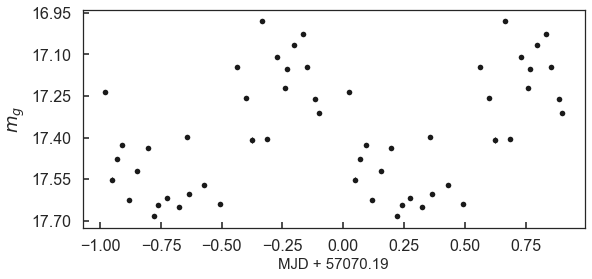

RRLYR AB 0.510517013253 0.241753531522


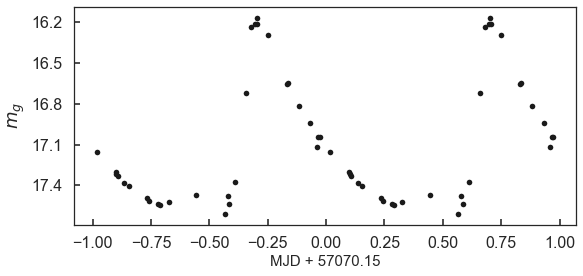

RRLYR AB 0.568711304326 0.213407157743


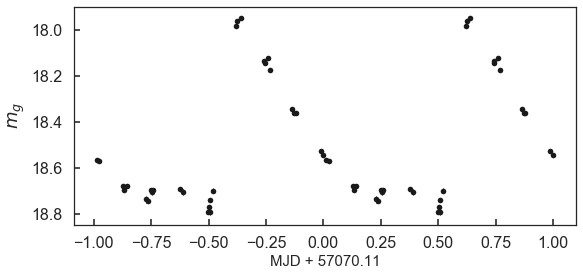

RRLYR AB 0.52111987787 0.194664719247


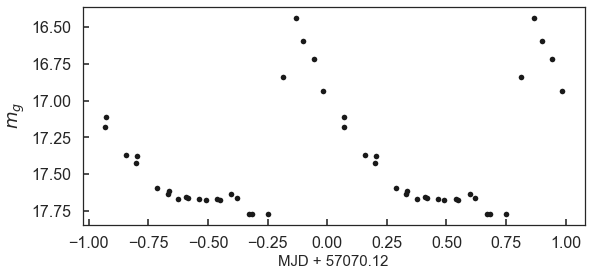

RRLYR AB 0.598099893473 0.139649843181


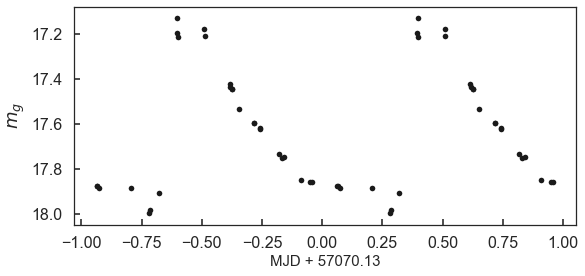

RRLYR nan 0.135128767192 0.969646266829


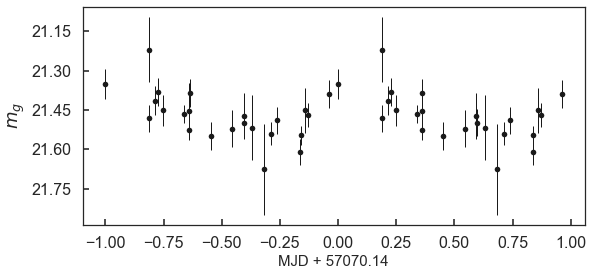

RRLYR nan 0.598107413003 0.0282617427901


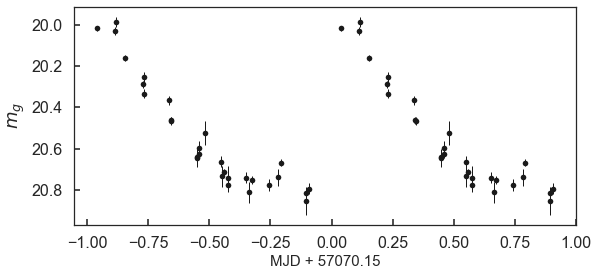

RRLYR nan 0.604363874844 0.243752181284


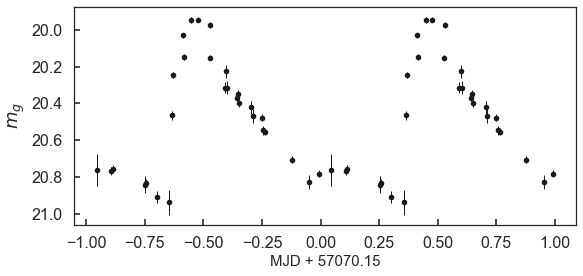

RRLYR nan 0.560568714579 0.636338119335


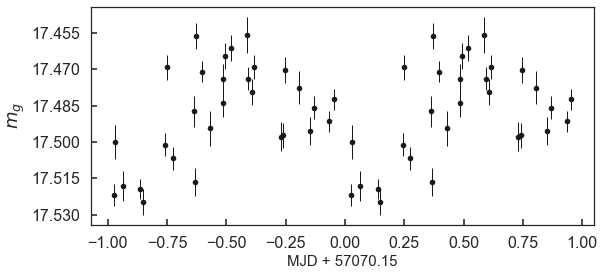

RRLYR AB 0.598113994649 0.0506261424954


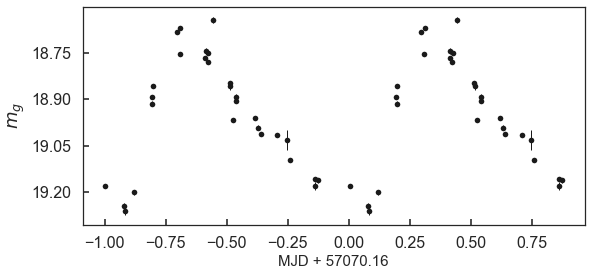

RRLYR nan 0.141387656864 0.540163541471


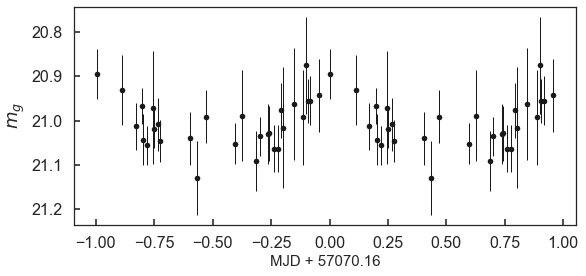

RRLYR nan 0.0225131101775 0.999934212794


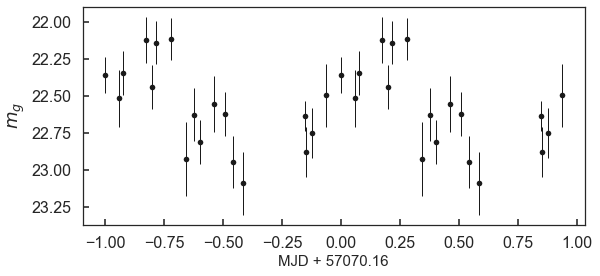

RRLYR nan 0.27884527957 0.011657245426


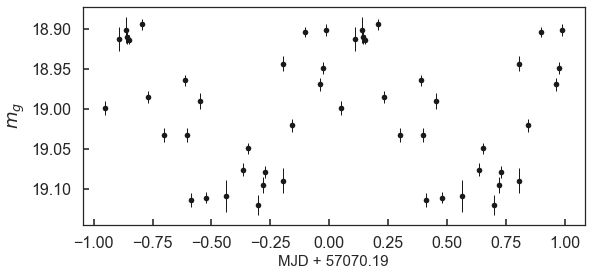

RRLYR nan 0.116287668667 0.999850286326


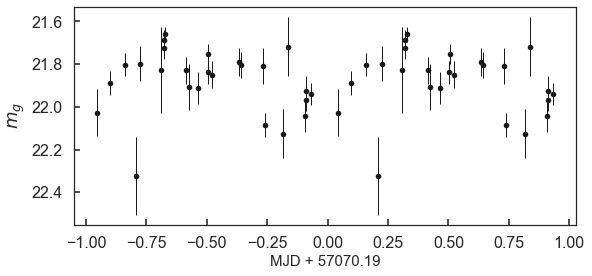

RRLYR AB 0.558982809152 0.998638342763
No lightcurve for other filter


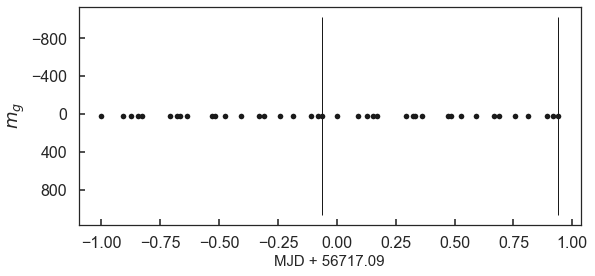

RRLYR AB 0.12212268117 0.999732210903
No lightcurve for other filter


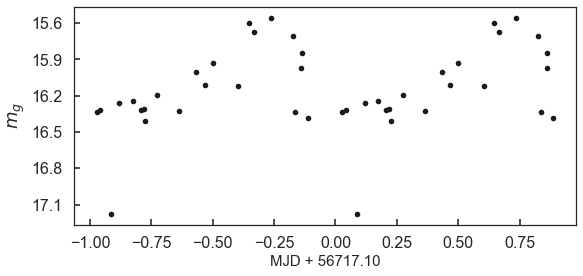

In [22]:
for ID in check:
    label = table_15.loc[ID,'Var_Type']
    sub = table_15.loc[ID,'Var_subType']
    #sub = 'Blazar'
    name = '2QZ J100011.9-020822'

    if label in ['RRLYR', 'EB', 'ROTVAR']:
        T = float(table_15.loc[ID,'PeriodGLS'])
    print label, sub, T, table_15.loc[ID,'Period_fit']
    #else:
    #    T = float(table_15.loc[ID,'PeriodLS'])
    #T = float(table_15.loc[ID,'WMCC_Period'])
    field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', ID)[0]
    try:
        time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD,
                                                       X, Y,extract=False)
    except:
        print 'fail during LC read'

    mask = (mag > np.median(mag) - 3*np.std(mag)) & (mag < np.median(mag) + 3*np.std(mag))
    if label == 'DSCT':
        mag = mag[mask]
        time = time[mask]
        err = err[mask]
        T = 0.060014
        sub = ''

    if label == 'LPV':
        T = 94.52509

    if label in ['EB'] : T *= 2
    phase = np.mod(time, T) / T
    sort_idx = np.argsort(phase)
    PHASE = phase[sort_idx]
    MAG = mag[sort_idx]
    ERR = err[sort_idx]

    MAG = np.concatenate([MAG,MAG])
    PHASE = np.concatenate([PHASE,PHASE+1])-1
    ERR = np.concatenate([ERR,ERR])

    fig, ax = plt.subplots(1,1, figsize=(9,4))

    #ax.errorbar(time[:-2] - time[0], mag[:-2], yerr=err[:-2],
    #            fmt='k.', lw=1, alpha=1)
    ax.errorbar(PHASE, MAG, yerr=ERR,
                fmt='k.', lw=1, alpha=1)
    #ax.text(0.04, 0.15, "P = %.3f d" % (T), fontsize=14, color='b',
    #        ha='left', va='top', transform=ax.transAxes)
    #ax.text(0.65, 0.15, '%s'% (name), fontsize=16, color='b',
    #        ha='left', va='top', transform=ax.transAxes)

    ax.set_xlabel('MJD + %.2f' % (time[0]), fontsize=15)
    ax.set_ylabel('$m_g$', fontsize=18)
    ax.invert_yaxis()

    nbins = len(ax.get_xticklabels())
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))

    if False:
        fig.savefig('%s/figures/lc_examples_%s_%s.pdf' % (mainpath, label, 'cand'),
                format='png', dpi=600,
                bbox_inches='tight')

    plt.show()


Blind15A_36_S14_0610_4037
Blind15A_16_S12_1264_0705
Blind15A_10_N17_1174_1967
Blind15A_48_N13_1900_3489
Blind15A_27_N4_1137_0808
Blind15A_16_N29_0097_2110


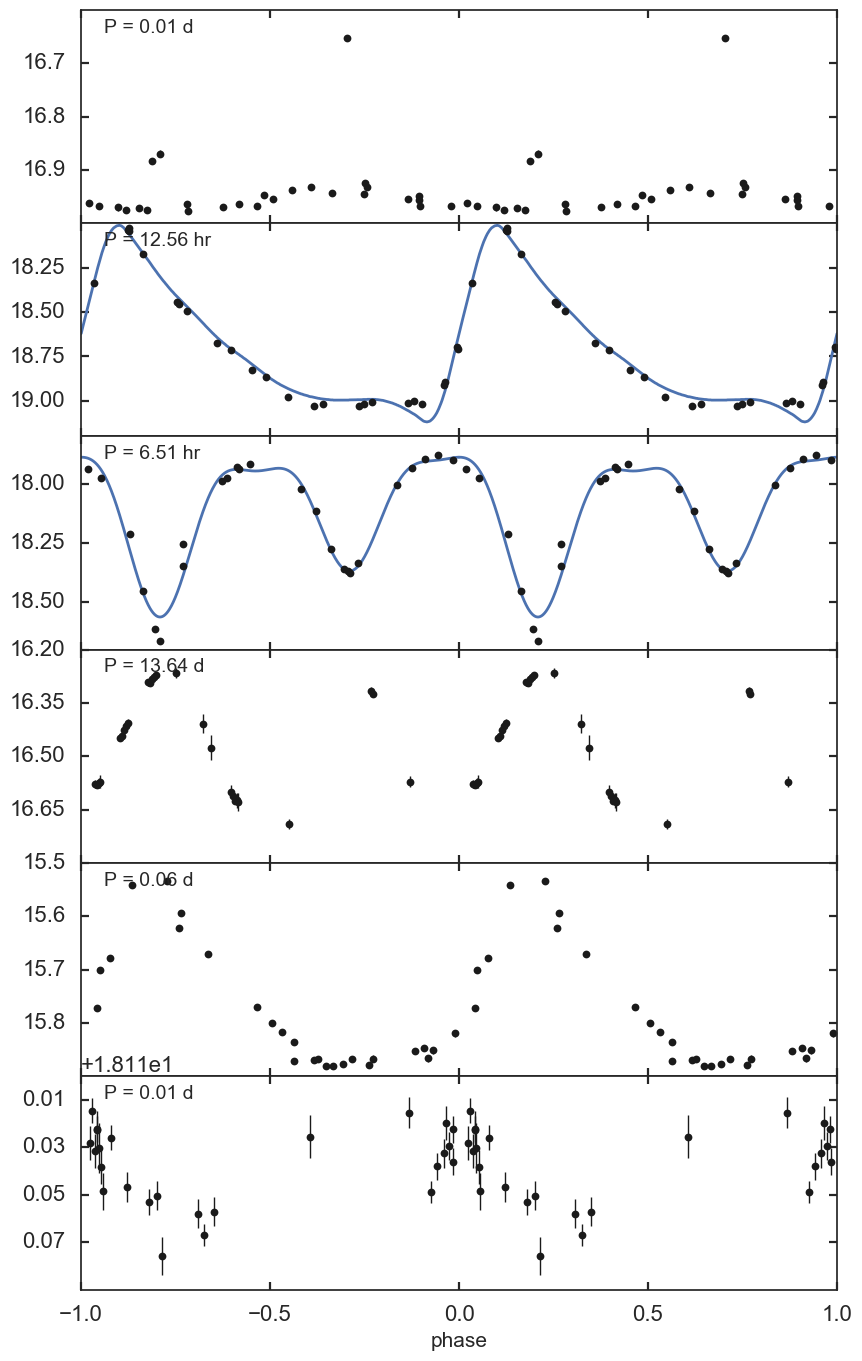

In [10]:
fig, ax = plt.subplots(6,1, figsize=(9,14), sharex=True)
for idx, ID in enumerate(index_goods[4:]):
    print '\r',ID
    label = table_15.loc[ID,'Var_Type']
    #print table_15.loc[ID,['Var_Type','FLUX_RADIUS','ELLIPTICITY',
    #                       'FWHM','FLAGS','Mean','Median_g',
    #           'Std','MedianAbsDev','Meanvariance','Eta_e',
    #           'Pred_Var_Type','Prob_Pred','PeriodLS',
    #           'Period_fit', 'WMCC_Period', 'WMCC_conf']]
    T = float(table_15.loc[ID,'PeriodLS'])
    #T = float(table_15.loc[ID,'WMCC_Period'])
    field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', ID)[0]
    try:
        time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD,
                                                       X, Y,extract=False)
    except:
        print 'fail during LC read'
        continue
        
    mask = (mag > np.median(mag) - 3*np.std(mag)) & (mag < np.median(mag) + 3*np.std(mag))
    if label == 'DSCT':
        mag = mag[mask]
        time = time[mask]
        err = err[mask]

    if label in ['EB','ROTVAR'] : T *= 2
    phase = np.mod(time, T) / T
    sort_idx = np.argsort(phase)
    PHASE = phase[sort_idx]
    MAG = mag[sort_idx]
    ERR = err[sort_idx]
    if label in ['ROTVAR', 'LPV', 'ZZ', 'DSCT']:
        MAG = np.concatenate([MAG,MAG])
        PHASE = np.concatenate([PHASE,PHASE+1])-1
        ERR = np.concatenate([ERR,ERR])
        ax.ravel()[idx].set_xlabel('phase', fontsize=15) 
    
    if label in ['RRLYR']:
        model = periodic.RRLyraeTemplateModeler('g')
        model.fit(time, mag, err)
        t_fit = np.linspace(0, T, 1000)
        phasefit = t_fit / T
        mag_fit = model.predict(t_fit, period=T)
        phasefit = np.concatenate([phasefit, phasefit+1])
        mag_fit = np.concatenate([mag_fit, mag_fit])
        ax.ravel()[idx].plot(phasefit-1, mag_fit, '-b', lw=2)
        MAG = np.concatenate([MAG,MAG])
        PHASE = np.concatenate([PHASE,PHASE+1])-1
        ERR = np.concatenate([ERR,ERR])
        ax.ravel()[idx].errorbar(PHASE, MAG, yerr=ERR,
                             fmt='k.', lw=1,alpha=1, label=label)
        ax.ravel()[idx].text(0.03, 0.96, "P = %.2f hr" %
                         (T * 24.), fontsize=14,
                         ha='left', va='top',
                         transform=ax.ravel()[idx].transAxes)
        ax.ravel()[idx].set_xlabel('phase', fontsize=15) 
    
    elif label in ['EB']:
        mtf = MultiTermFit(2*np.pi/T, 4)
        mtf.fit(time, mag, err)
        phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)
        ax.ravel()[idx].plot(phase_fit, y_fit, '-b', lw=2)
        ax.ravel()[idx].plot(phase_fit-1, y_fit, '-b', lw=2)
        ax.ravel()[idx].errorbar(phased_t, mag, yerr=err,
                             fmt='k.', lw=1,alpha=1, label=label)
        ax.ravel()[idx].errorbar(phased_t-1, mag, yerr=err,
                             fmt='k.', lw=1,alpha=1, label=label)
        ax.ravel()[idx].text(0.03, 0.96, "P = %.2f hr" %
                         (T * 24.), fontsize=14,
                         ha='left', va='top',
                         transform=ax.ravel()[idx].transAxes)
        ax.ravel()[idx].set_xlabel('phase', fontsize=15) 
    else:
        ax.ravel()[idx].errorbar(PHASE, MAG, yerr=ERR,
                             fmt='k.', lw=1,alpha=1, label=label)
        ax.ravel()[idx].text(0.03, 0.96, "P = %.2f d" %
                         (T), fontsize=14,
                         ha='left', va='top',
                         transform=ax.ravel()[idx].transAxes)
    
        ax.ravel()[idx].set_xlabel('phase', fontsize=15) 
    
    ax.ravel()[idx].invert_yaxis()
    nbins = len(ax.ravel()[idx].get_xticklabels())
    ax.ravel()[idx].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))

        
fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig('%s/lc_examples_P.pdf' % paper_fig_path, format='pdf', dpi=600,
            bbox_inches='tight')
plt.show()

In [59]:
table_file = '%s/tables/Blind15A_tables+feat_pl_var_type_spCL_spClass.csv'\
              %(mainpath)
#table_file = '%s/tables/Blind15A_label_sample_new.csv'\
#              %(mainpath)
table_15 = pd.read_csv(table_file)
table_15 = table_15.set_index('ID')

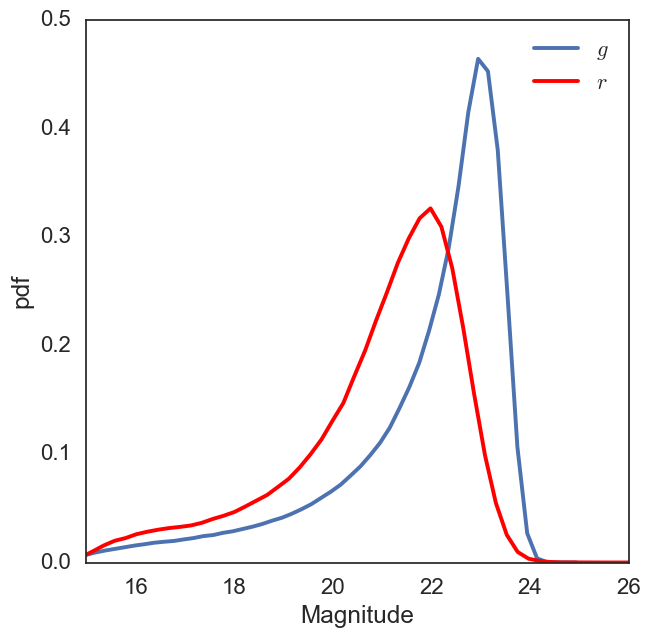

In [57]:
plt.figure(figsize=(7,7))
sns.kdeplot(table_15.Median_g, shade=False, label=r'$g$')
sns.kdeplot(table_15.Median_r, shade=False, color='red', label=r'$r$')
plt.xlim(15,26)
plt.xlabel('Magnitude')
plt.ylabel('pdf')
plt.show()

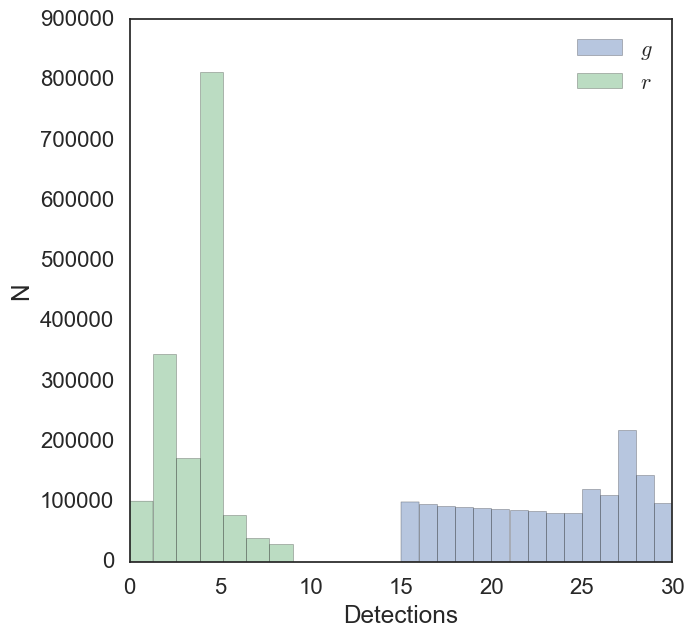

In [56]:
plt.figure(figsize=(7,7))
sns.distplot(table_15.Occu_g, kde=False, label='$g$', bins=15)
sns.distplot(table_15.Occu_r, kde=False, label='$r$', bins=7)
plt.legend(loc='best')
plt.xlabel('Detections')
plt.ylabel('N')
plt.show()

In [60]:
table_file = '%s/tables/Blind14A_tables+feat_pl_var_type_spCL_spClass.csv'\
              %(mainpath)
#table_file = '%s/tables/Blind15A_label_sample_new.csv'\
#              %(mainpath)
table_14 = pd.read_csv(table_file)
table_14 = table_14.set_index('ID')

In [61]:
all_years = pd.concat([table_15, table_14])
print all_years.shape

(2537644, 86)


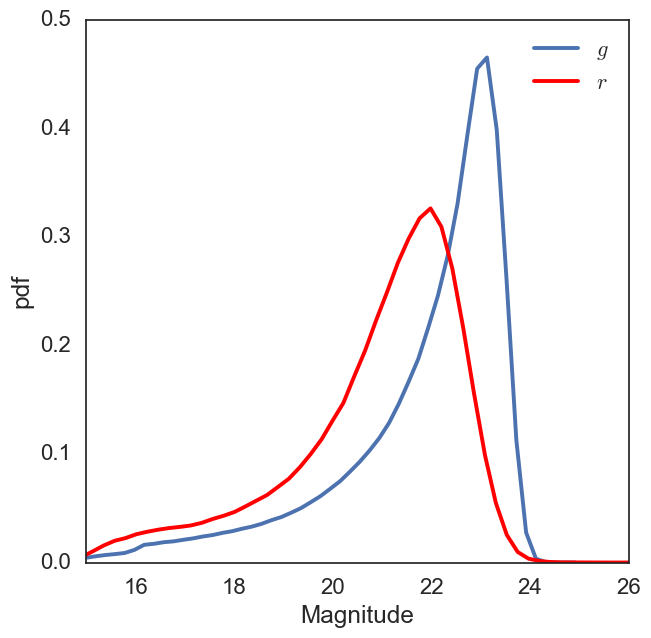

In [63]:
plt.figure(figsize=(7,7))
sns.kdeplot(all_years.Median_g, shade=False, label=r'$g$')
sns.kdeplot(all_years.Median_r, shade=False, color='red', label=r'$r$')
plt.xlim(15,26)
plt.xlabel('Magnitude')
plt.ylabel('pdf')
plt.show()

In [73]:
all_years.Occu_r.fillna(0, inplace=True)

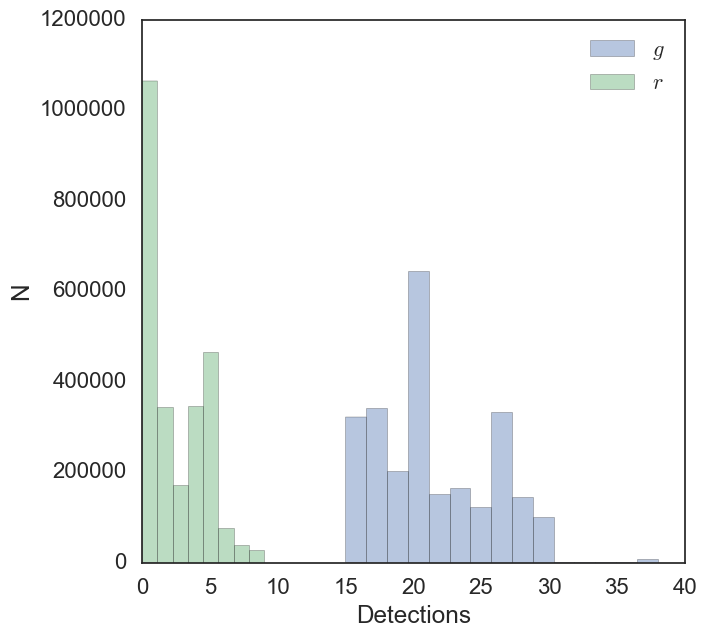

In [82]:
plt.figure(figsize=(7,7))
sns.distplot(all_years.Occu_g, kde=False, label='$g$', bins=15)
sns.distplot(all_years.Occu_r, kde=False, label='$r$', bins=8)
plt.legend(loc='best')
plt.xlabel('Detections')
plt.ylabel('N')
plt.show()